In [ ]:
# Install TensorFlow Decision Forests
!pip -q install tensorflow_decision_forests


     |████████████████████████████████| 6.2MB 6.6MB/s 


# Inicio

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
import tensorflow_decision_forests as tfdf

from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from tensor_forest.python import tensor_forest
#from tensorflow.python.ops import resources




COLAB = ('COLAB_GPU' in os.environ)  # True if we are in a Colab environment

# Origin of Zip file
FILENAME1 = 'weather_features.csv'
FILENAME2 = 'energy_dataset.csv'

if COLAB:
    DIRNAME = '/content/drive/My Drive/Colab Notebooks/ENERGY/DATA/'
else:
    DIRNAME = './'

if COLAB:
    # Mount drive
    from google.colab import drive
    import shutil
    
    drive.mount("/content/drive")
    shutil.copy(DIRNAME+FILENAME1, FILENAME1)
    shutil.copy(DIRNAME+FILENAME2, FILENAME2)

print('Ready!!')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


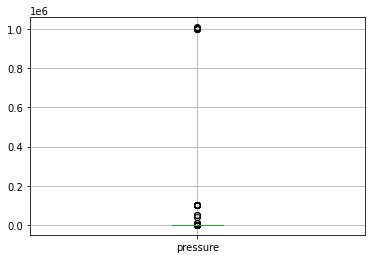

                        time  generation biomass  ...  price day ahead  price actual
0  2015-01-01 00:00:00+01:00               447.0  ...            50.10         65.41
1  2015-01-01 01:00:00+01:00               449.0  ...            48.10         64.92
2  2015-01-01 02:00:00+01:00               448.0  ...            47.33         64.48
3  2015-01-01 03:00:00+01:00               438.0  ...            42.27         59.32
4  2015-01-01 04:00:00+01:00               428.0  ...            38.41         56.04

[5 rows x 29 columns]
Encontramos 0 Valores perdidos p NaNs en df_final.

Encontramos 0 filas duplicadas en df_energia based en todas las columnas.


In [ ]:
## DATASET ATMOSFERICO
#leemos el dataset del Tiempo y indicamos que son fechas la columna 'dt_iso'

df_atmosferico = pd.read_csv(FILENAME1, parse_dates=['dt_iso'])


#Elimina columnas innecesarias sobre el dataset (no crea copia)
df_atmosferico.drop(['weather_main', 'weather_id', 'weather_description', 
                 'weather_icon', 'rain_3h'], axis=1, inplace = True)

#Elimina filas con la misma fecha y ciudad (se queda con la primera)
df_atmosferico.drop_duplicates(subset=['dt_iso', 'city_name'], keep='first',
                           inplace = True)

#Definimos un Indice para nuestro dataset a la vez que hacemos Cast para que sean fechas.
df_atmosferico.set_index(pd.to_datetime(df_atmosferico['dt_iso'], utc=True, 
                                    infer_datetime_format=True), 
                                    inplace=True, drop=True)

#Elimina la columna de la fecha porque ya la ha hecho indice
df_atmosferico.drop(['dt_iso'], axis=1, inplace = True)


#Define el nombre del indice como "time"
df_atmosferico.index.name = 'time'

#Selecciona las columnas, creo que pasa los numeros de int a float...
cols = df_atmosferico.select_dtypes(include=[np.int64]).columns

for col in cols:
    df_atmosferico[col] = df_atmosferico[col].values.astype(np.float64)

#Boxplot de pressure
boxplot = df_atmosferico.boxplot(column = ['pressure'])
boxplot.plot()

plt.show()

#Outliers
df_atmosferico.loc[df_atmosferico.pressure > 1051, 'pressure'] = np.nan
df_atmosferico.loc[df_atmosferico.pressure < 931, 'pressure'] = np.nan
df_atmosferico.loc[df_atmosferico.wind_speed > 50, 'wind_speed'] = np.nan

#Se eliminan esas porque en la historia nunca se han registrado
#temperaturas superiores/inferiores

#Rellena los NaN vía interpolación
df_atmosferico.interpolate(method='linear', limit_direction='forward', 
                       inplace=True, axis=0)

## DATASET ENERGIA
#Leemos el dataset de Consumo e indicamos que son fechas la columna 'time'.
df_energia = pd.read_csv(FILENAME2, parse_dates=['time'])

print(df_energia.head(5))
#Definimos el indice como la columna 'Time'
df_energia.set_index(pd.to_datetime(df_energia['time'], utc=True, 
                                    infer_datetime_format=True), 
                     inplace=True, drop=True)
#Definimos el nombre del indice (igual que el de la columna)
df_energia.index.name = 'time'
#Eliminamos todas las columnas que no son de utilidad + la que hemos hecho indice.
df_energia.drop(['time', 'generation fossil coal-derived gas',
                'generation fossil oil shale', 'generation fossil peat',
                'generation geothermal',
                'generation hydro pumped storage aggregated', 
                'generation marine', 'generation wind offshore', 
                'forecast wind offshore eday ahead', 'total load forecast', 
                'forecast solar day ahead', 'forecast wind onshore day ahead'], 
               axis=1, inplace = True)

#Rellenamos los NaN por medio de la interpolación
df_energia.interpolate(method='linear', limit_direction='forward', inplace=True, 
                      axis=0)




# Dividimos el dataset del tiempo en 5, uno por cada ciudad 
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_atmosferico.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]





# Final Merge #Conexion = Merge, unir Dataframes
df_final = df_energia
for df in dfs:
    ##Preguntar estas 3 lineas:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

# LIMPIAMOS EL ENTORNO
del FILENAME1, FILENAME2, DIRNAME
del dfs, df_1, df_2, df_3, df_4, df_5, city, city_str, col, cols
del df_atmosferico, df_energia

print('Encontramos {} Valores perdidos p NaNs en df_final.'
      .format(df_final.isnull().values.sum()))
print('\nEncontramos {} filas duplicadas en df_energia based en todas las columnas.'
      .format(df_final.duplicated(keep='first').sum()))

In [ ]:
## Generación de caracteristicas
##Genera 3 columnas: hora, semana & mes
df_final['hour'] = df_final.index.hour
df_final['weekday'] = df_final.index.weekday
df_final['month'] = df_final.index.month

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

    weekday = df_final['weekday'].iloc[i]    
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

# Temperature 
ciudades = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in ciudades:
    df_final['temp_range_{}'.format(city)] = abs(
        df_final['temp_max_{}'.format(city)] - 
        df_final['temp_min_{}'.format(city)]
    )

# Calculamos el peso de cada ciudad
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000
peso_Madrid = 6155116 / total_pop
peso_Barcelona = 5179243 / total_pop
peso_Valencia = 1645342 / total_pop
peso_Seville = 1305342 / total_pop
peso_Bilbao = 987000 / total_pop
peso_ciudades = {'Madrid': peso_Madrid, 
                  'Barcelona': peso_Barcelona,
                  'Valencia': peso_Valencia,
                  'Seville': peso_Seville,
                  'Bilbao': peso_Bilbao}
                  
#Creamos un array de 0s con la longitud del data set                  
temp_weighted = [0]*len(df_final)

for city in ciudades:
    temp_weighted += df_final['temp_{}'.format(city)] * peso_ciudades.get('{}'.format(city))
df_final['temp_weighted'] = temp_weighted

df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

del ciudades, city, total_pop, peso_Madrid, peso_Barcelona
del peso_Seville, peso_Bilbao, peso_ciudades, temp_weighted


df_final.head(10)


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,hour,weekday,month,business hour,temp_range_Barcelona,temp_range_Bilbao,temp_range_Madrid,temp_range_Seville,temp_range_Valencia,temp_weighted,generation coal all
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,23,0,12,0.0,0.0,0.0,0.0,0.0,0.0,273.181801,5150.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,273.188663,5083.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,272.557335,4904.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,272.554211,4385.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,272.572446,4027.0
2015-01-01 04:00:00+00:00,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,74.0,34.0,188.0,4618.0,19905.0,35.72,53.63,280.467,280.467,280.467,1037.0,100.0,5.0,32.0,

In [ ]:

# Definimos la funcion datos_multivariables
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

train_end_idx = 27048 #indice hasta donde llegan los datos de entrenamiento
cv_end_idx = 31056    #indice hasta donde llegan los datos de validación
test_end_idx = 35064  #indice hasta donde llegan los datos de test

y = df_final['price actual'].values #Datos Target
y = y.reshape(-1, 1) #En columna
X = df_final[df_final.columns.drop('price actual')].values  #En X el datset sin la columna de precios

scaler_X = MinMaxScaler(feature_range=(0, 1)) #Creamos un escalador para las X
scaler_y = MinMaxScaler(feature_range=(0, 1)) #creamos un escalador para las Y

scaler_X.fit(X[:train_end_idx]) #Ajustamos escalador para las X
scaler_y.fit(y[:train_end_idx]) #Ajustamos el otro escalador para las Y (debe ser distinto)

X_norm = scaler_X.transform(X) #Escalamos las X
y_norm = scaler_y.transform(y) #Escalamos las Y

#Analisis de los Componenetes principales (eliminamos los que tienen una correlacion superior a 85%)
#Mejora levemente la predicción
pca = PCA(n_components=0.85) #Creamos el PCA
pca.fit(X_norm[:train_end_idx]) #Ajustamos el PCA para los datos de entrenamiento

X_pca = pca.transform(X_norm) 

past_history = 24 #Cada chunk de 24
future_target = 0 #El target justo en el que toca

dataset_norm = np.concatenate((X_pca, y_norm), axis=1) 
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)



# Definimos parametros comunes para todos los Modelos que utilizaremos
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError() #Objeto para error
metric = [tf.keras.metrics.RootMeanSquaredError()] #metrica que utilizaremos para que cuadre con nuestro error

#Programamos la tasa de aprendizaje
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))

#para que pare si deja de aprender en 10 iteracciones
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

#Datos de test en columna
y_test = y_test.reshape(-1, 1)

#Datos de test a la inversa
y_test_inv = scaler_y.inverse_transform(y_test) ##Mirar qué transformación

Funciones necesarias


In [ ]:
#Funcion para los ajustes de nuestro modelo (copilacion, optimizador, Check Point..)
def ajustes_modelo(checkPoint_file, opt, model):

    #Vamos a ir guardando en el archivo .h5 el mejor modelo (con los mejores pesos)
    #Guardamos solo el MEJOR modelo ('save_best_only')  
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    checkPoint_file, save_best_only= True)
    
    #Determinamos el optimizador que vamos utilizar
    optimizer = tf.keras.optimizers.Adam(lr=opt, amsgrad=True)

    #Especificamos la configuración del entrenamiento:
    #¿Qué optimizador utilizamos para entrenamiento?
    #¿Qué metrica utilizamos para monitorizar?
    #¿Qué pérdidas calculamos?
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics = metric)
    
    return model_checkpoint, model



#Funcion que representa gráficamente

def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    #Visualizamos ciclos VS perdidas y aciertos en Entrenamiento y Validación
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()
    #Fin función de pintar RMSE

def show_prediction(plot_data,delta,title):

    labels = ["Historial", "Verdadero Futuro", "Predicción Modelo"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]),0))

    if delta:
        future = delta
    else:
         future = 0
    
    plt.title(title)
    
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()

    return


def predicciones_test(checkPoint_file):

    #Restauramos siempre el mejor modelo obtenido que estaba aqui guardado
    model = tf.keras.models.load_model(checkPoint_file)

    #Generamos las predicciones
    prediccion = model.predict(X_test)
    model_prediccion = scaler_y.inverse_transform(prediccion)

    #Calculamos y exponemos el error
    rmse_mult_model = sqrt(mean_squared_error(y_test_inv, 
                                             model_prediccion))
    print('RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante: {}' .format(round(rmse_mult_model, 3)))

    MAE = abs((y_test - prediccion)).mean()
    print("MAE del precio de la electricidad, pronóstico multivariante: {}.".format(round(MAE,3)))
    return prediccion




#Funcion para calcular las predicciones con los datos de validacion

num = 1 #¿Con cuantos conjuntos de validacion vamos a hacer predicciones? 
step = 0 #¿Cual es el paso hasta la prediccion?

def predicciones_validacion(num,step,model):

    print('Vamos a hacer predicciones para 2 conjuntos de valores del conjunto de validación:')

    for x, y in validation.take(num):
        show_prediction(
            [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
            step,
            "Single Step Prediction",
        )

def real_VS_predicho(y_test, prediccion_test):
    print('\n')
    print('\n')
    print('A continuacion se presenta la grafica que compara')
    print('el valor real con el valor predicho:')

#   plt.scatter(y_test, prediccion_test, markersize=10)
    plt.scatter(y_test, prediccion_test, s=1)
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()


def grafica_prediccion_tiempo(horas_a_representar):
    t = df_final.index[31057+23:35064]
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(t[0:horas_a_representar], y_test[0:horas_a_representar], label='Datos Reales')
    plt.plot(t[0:horas_a_representar], prediccion_T[0:horas_a_representar], label='Predicciones de Test')
    plt.legend()
    plt.title('Precio real y precio predicho a la vez')


In [ ]:
FILENAME3 = 'df_final.csv'
DIRNAME = '/content/drive/My Drive/Colab Notebooks/ENERGY/DATA/'
df_final.to_csv(DIRNAME+FILENAME3)

# Redes neuronales recurrentes

LSTM

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


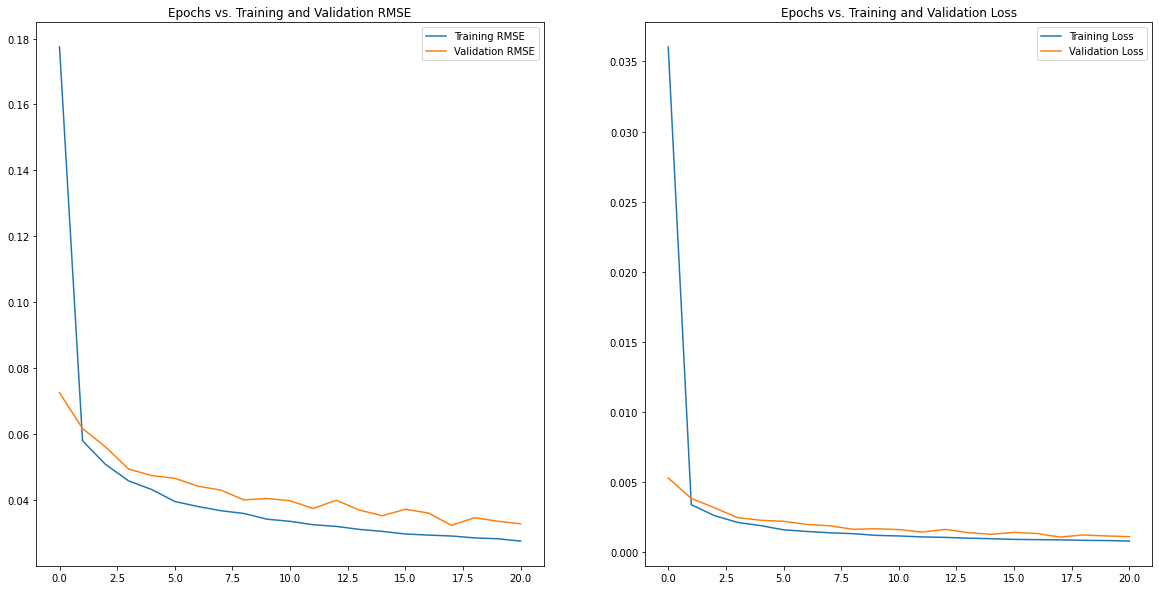

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante: 2.993


NameError: ignored

In [ ]:

##Creamos el modelos secuecial LSTM
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])



checkPoint_file = 'multivariate_lstm.h5'
opt = 6e-3
num_horas_a_representar = 168


model_checkpoint, multivariate_vainilla_lstm = ajustes_modelo(checkPoint_file,opt, multivariate_lstm)

#Entrenamos el modelo con fit() y nos quedamos con el objeto history
#El objeto history, contien los valores de pérdida y métricos de entrenamientos
history = multivariate_lstm.fit(train, epochs=120, verbose = 0,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])
plot_model_rmse_and_loss(history)

prediccion_T = predicciones_test(checkPoint_file)

real_VS_predicho(y_test, prediccion_T)

predicciones_validacion(num,step,multivariate_lstm)

grafica_prediccion_tiempo(num_horas_a_representar)

multivariate_lstm.summary()

VAINILLA LSTM (muy simple)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
845/845 [==============================] - 5s 5ms/step - loss: 0.0059 - root_mean_squared_error: 0.0729 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 2/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 3/120
845/845 [==============================] - 4s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 4/120
845/845 [==============================] - 4s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 5/120
845/845 [==============================] - 4s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 9.3626e-04 - val_root_mean_squared_error: 0.0306
Epoch 6/120
845/845 [==============================] - 4s 4ms/step - loss: 9.3711e-04 - root_mean_squared_error: 0.0306 - val_loss:

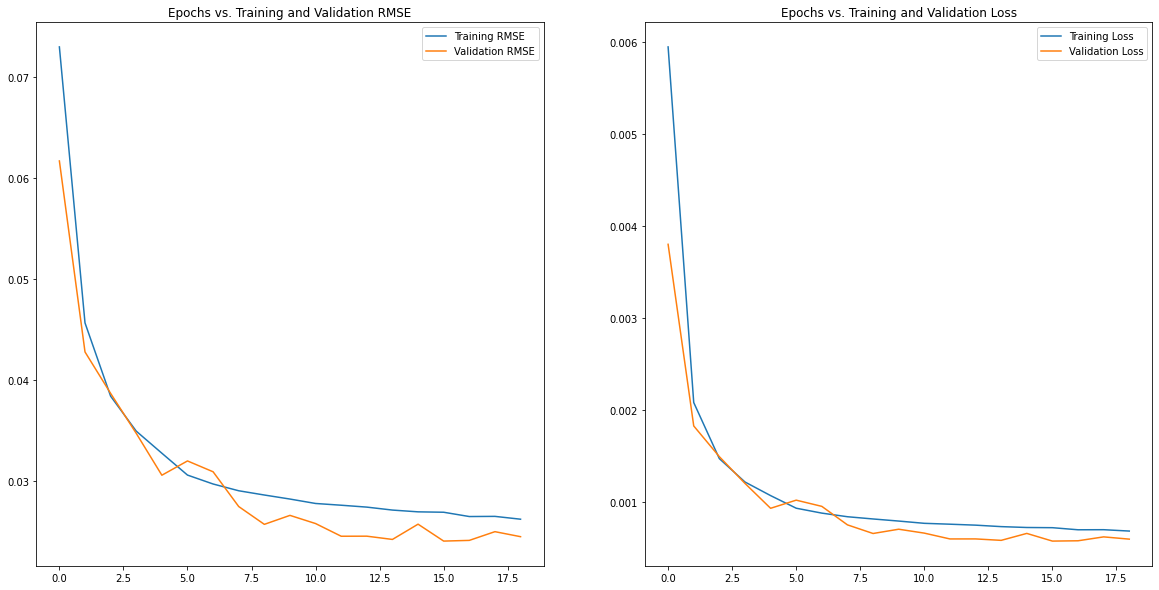

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante: 2.324
MAE del precio de la electricidad, pronóstico multivariante: 0.016.




A continuacion se presenta la grafica que compara
el valor real con el valor predicho:


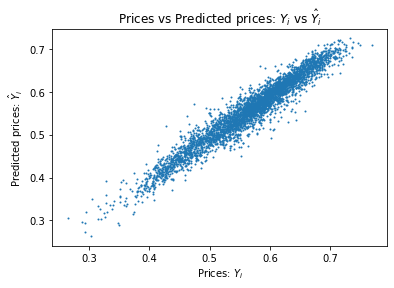

Vamos a hacer predicciones para 2 conjuntos de valores del conjunto de validación:


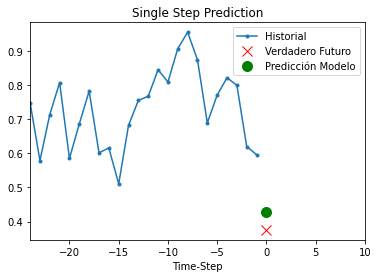

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 50)            14200     
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1201      
Total params: 15,401
Trainable params: 15,401
Non-trainable params: 0
_________________________________________________________________


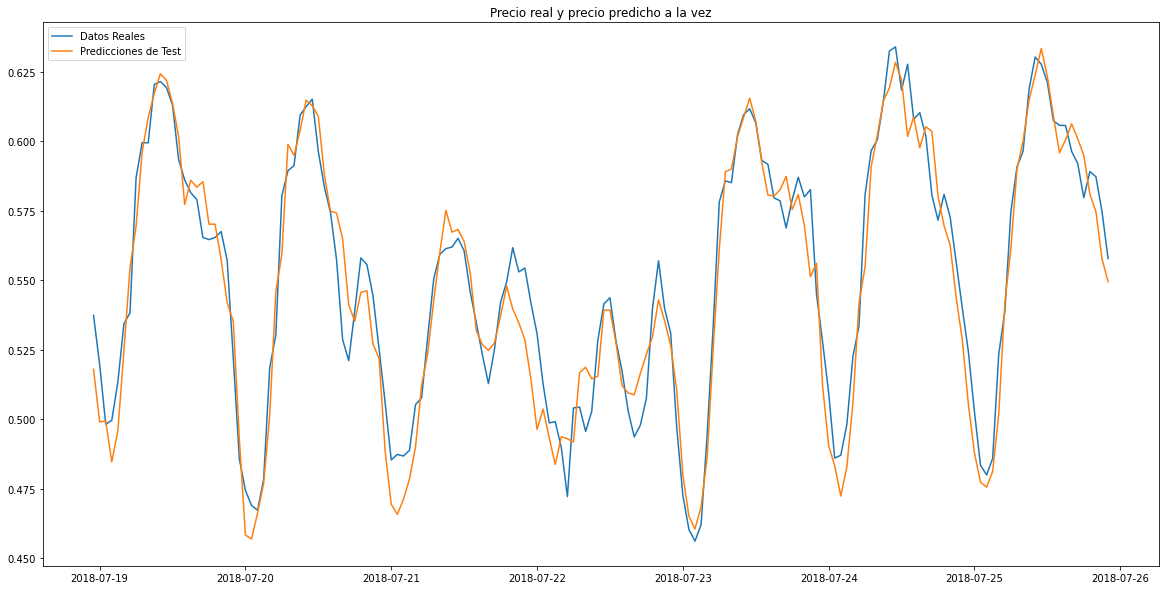

In [ ]:
#Limpiamos el anterior
tf.keras.backend.clear_session()

#Definimos el modelo
multivariate_vainilla_lstm =tf.keras.models.Sequential([
    LSTM(50, input_shape=input_shape, return_sequences = True),
    Flatten(), #Aplana, dimensiona
    Dropout(0.4), #Reduce el aprendizaje
    Dense(1)                                                                      
])


checkPoint_file = 'multivariate_vainilla_lstm.h5'
opt = 4e-3
num_horas_a_representar = 168

model_checkpoint, multivariate_vainilla_lstm = ajustes_modelo(checkPoint_file,opt, multivariate_vainilla_lstm)


#Entrenamos nuestro modelo LSTM Vainilla
history = multivariate_vainilla_lstm.fit(train, epochs=120,
                                         validation_data=validation, verbose = 1,
                                         callbacks = [early_stopping,
                                                      model_checkpoint])

#Lo pintamos
plot_model_rmse_and_loss(history)

prediccion_T = predicciones_test(checkPoint_file)

real_VS_predicho(y_test, prediccion_T)

predicciones_validacion(num,step,multivariate_vainilla_lstm)

grafica_prediccion_tiempo(num_horas_a_representar)

#Resumen del modelo 
multivariate_vainilla_lstm.summary()


Stacked LSTM V2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


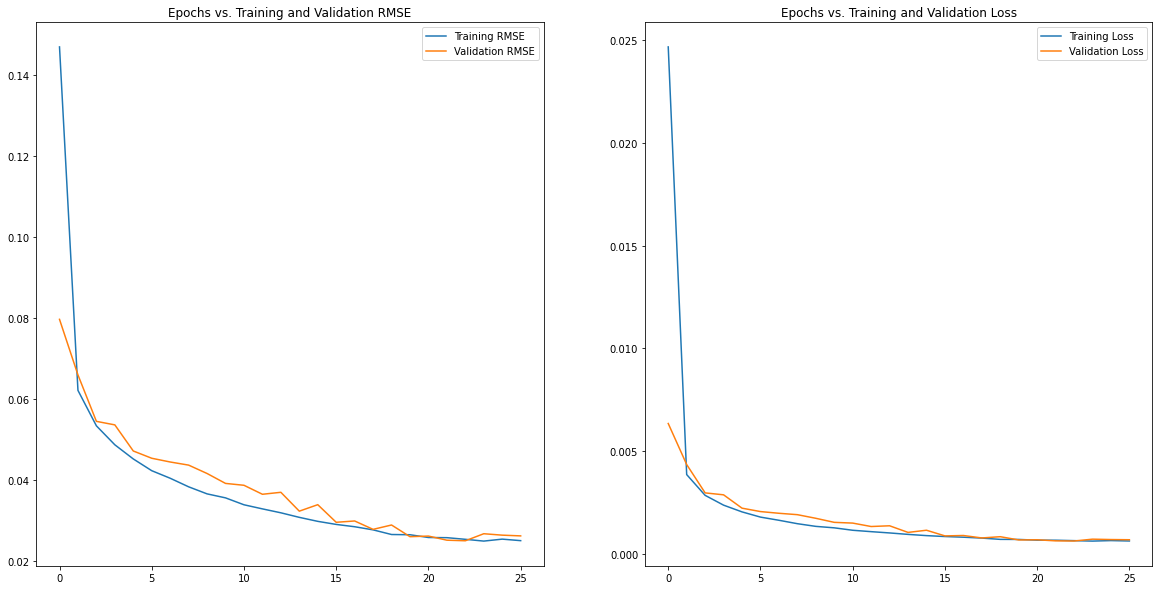

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante: 2.337
MAE del precio de la electricidad, pronóstico multivariante: 0.017.




A continuacion se presenta la grafica que compara
el valor real con el valor predicho:


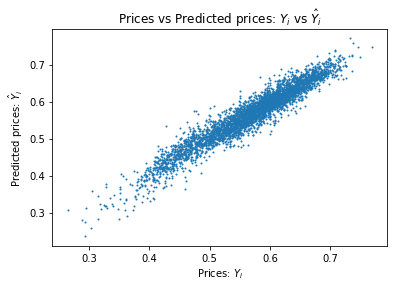

Vamos a hacer predicciones para 2 conjuntos de valores del conjunto de validación:


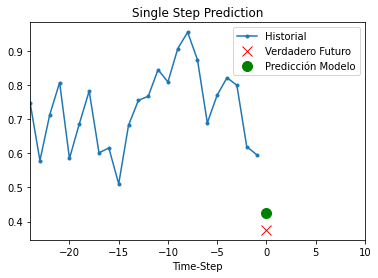

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 250)           271000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 150)           240600    
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               540150    
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 1,051,901
Trainable params: 1,051,901
Non-trainable params: 0
______________________________________________

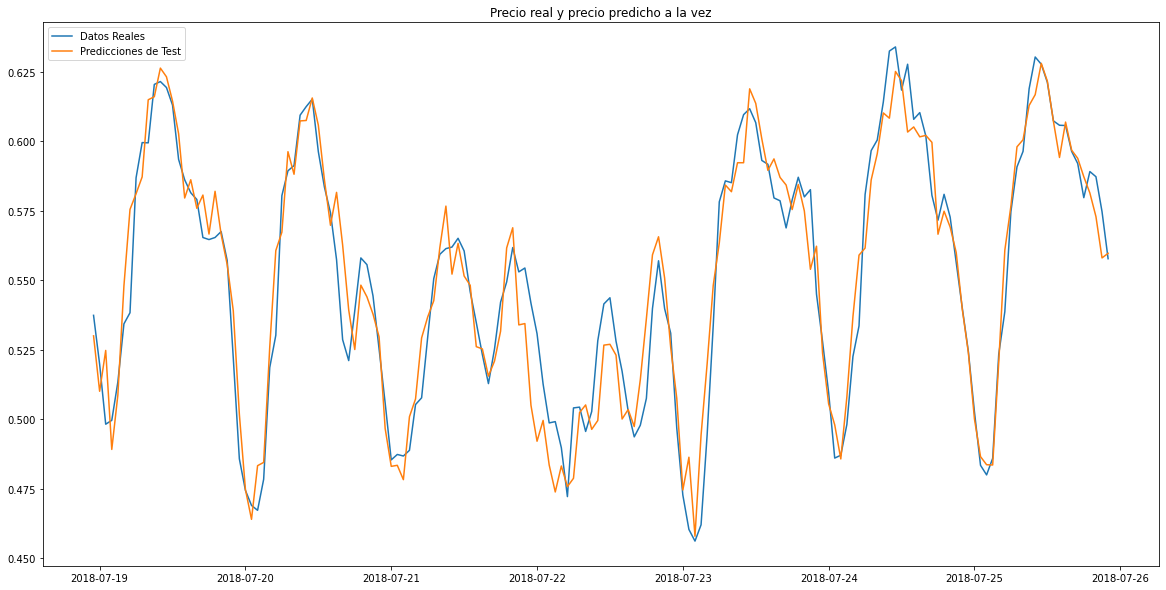

In [ ]:
#Limpiamos la sesión anterior
tf.keras.backend.clear_session()

#Configuramos y creamos nuestro modelo
multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

checkPoint_file = 'multivariate_stacked_lstm.h5'
opt = 3e-3
num_horas_a_representar = 168

model_checkpoint, multivariate_stacked_lstm = ajustes_modelo(checkPoint_file,opt, multivariate_stacked_lstm)

#Entrenamos nuestro modelo
history = multivariate_stacked_lstm.fit(train, epochs=120, verbose = 0,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])
#Representamos perdidas y RMSE
plot_model_rmse_and_loss(history)

prediccion_T = predicciones_test(checkPoint_file)

real_VS_predicho(y_test, prediccion_T)


predicciones_validacion(num,step,multivariate_stacked_lstm)

grafica_prediccion_tiempo(num_horas_a_representar)


#Resumen del modelo 
multivariate_stacked_lstm.summary()


MAE = abs((y_test - prediccion_T)).mean()
print("MAE del precio de la electricidad, pronóstico multivariante de Stacked-LSTM: {}.".format(MAE))





CNN-LSTM


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


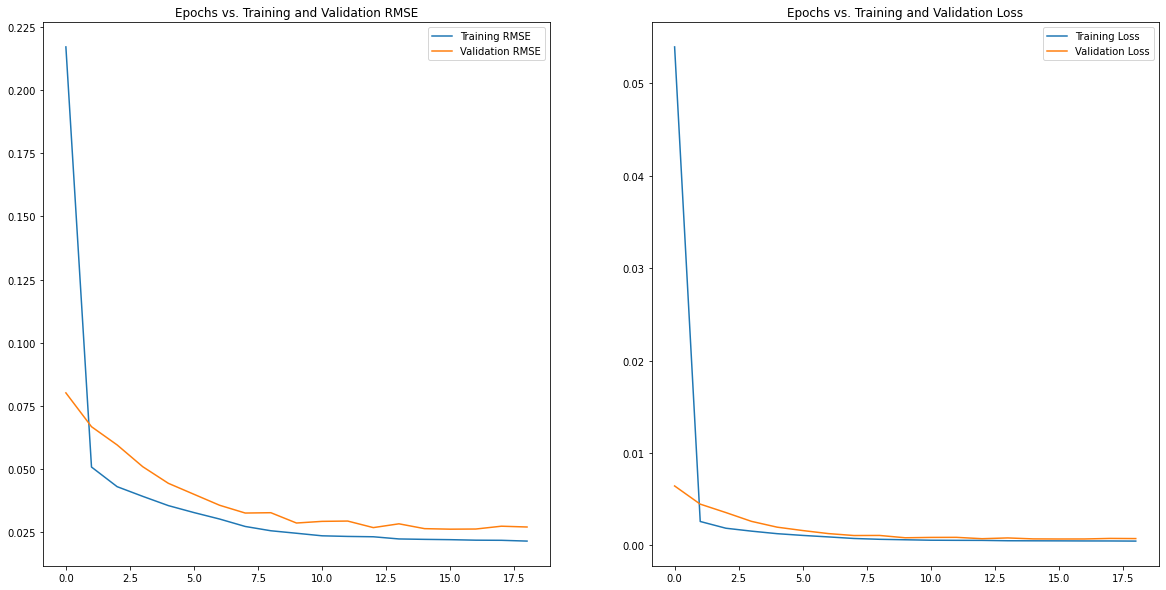

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante: 2.497
MAE del precio de la electricidad, pronóstico multivariante: 0.018.




A continuacion se presenta la grafica que compara
el valor real con el valor predicho:


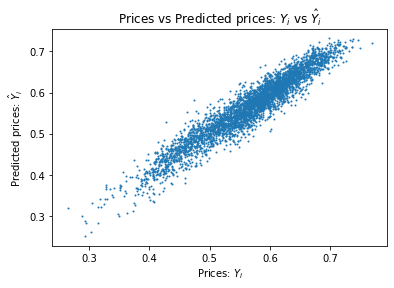

Vamos a hacer predicciones para 2 conjuntos de valores del conjunto de validación:


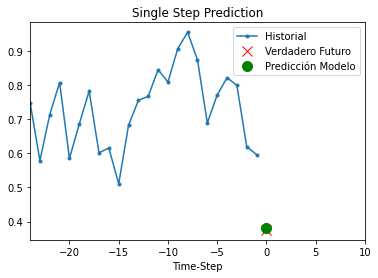

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 200)           8200      
_________________________________________________________________
lstm (LSTM)                  (None, 24, 200)           320800    
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               720150    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 1,049,301
Trainable params: 1,049,301
Non-trainable params: 0
_________________________________________________________________


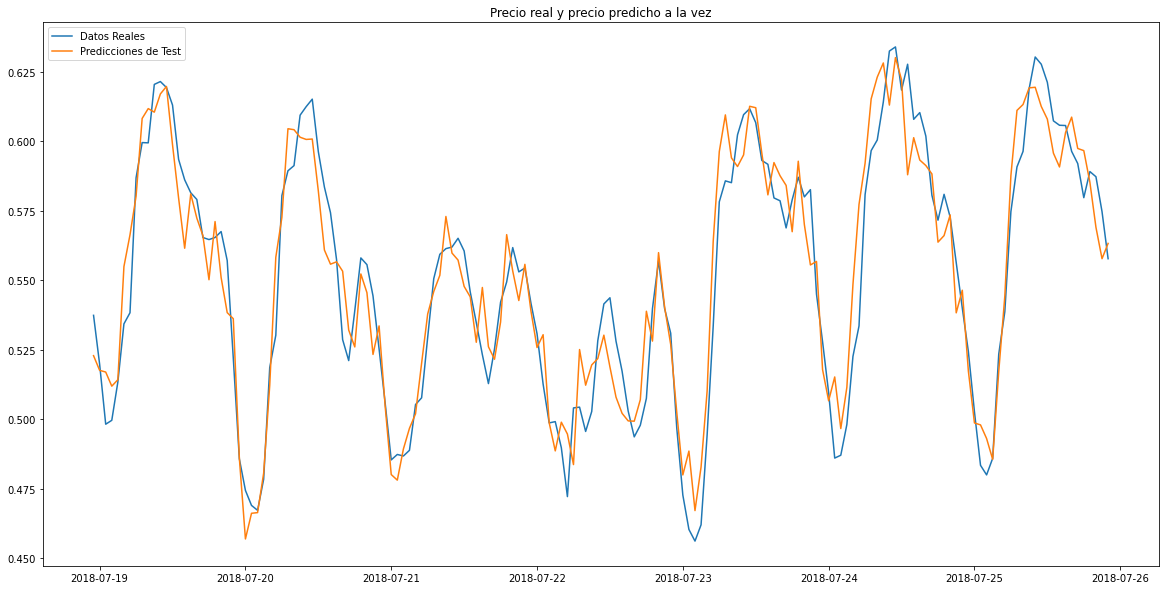

In [ ]:
#Limpiamos sesión anterior
tf.keras.backend.clear_session()

#Configuramos nuestro modelo y sus capas 
#100 100 50
multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=200, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(200, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(1)
])

checkPoint_file = 'multivariate_cnn_lstm.h5'
opt = 3e-3
num_horas_a_representar = 168

model_checkpoint, multivariate_cnn_lstm = ajustes_modelo(checkPoint_file,opt, multivariate_cnn_lstm)

#Entrenamos nuestro modelo
history = multivariate_cnn_lstm.fit(train, epochs=120, verbose = 0,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

#Representamos perdidas y RMSE
plot_model_rmse_and_loss(history)

prediccion_T = predicciones_test(checkPoint_file)

real_VS_predicho(y_test, prediccion_T)


predicciones_validacion(num,step,multivariate_cnn_lstm)

grafica_prediccion_tiempo(num_horas_a_representar)


#Resumen del modelo 
multivariate_cnn_lstm.summary()




# Modelos Autoregresivos

Modelo Arima
ARIMA(1,1,1)

Δyt = a1Δyt-1 + ϵt + b1ϵt-1 where Δyt = yt - yt-1

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                27047
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -73866.345
Method:                       css-mle   S.D. of innovations              3.714
Date:                Thu, 24 Jun 2021   AIC                         147738.689
Time:                        09:44:42   BIC                         147763.305
Sample:                             1   HQIC                        147746.627
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.712e-07      0.019   1.43e-05      1.000      -0.037       0.037
ar.L1.D.y     -0.1896      0.006    -31.761      0.000      -0.201      -0.178
                                    Roots           

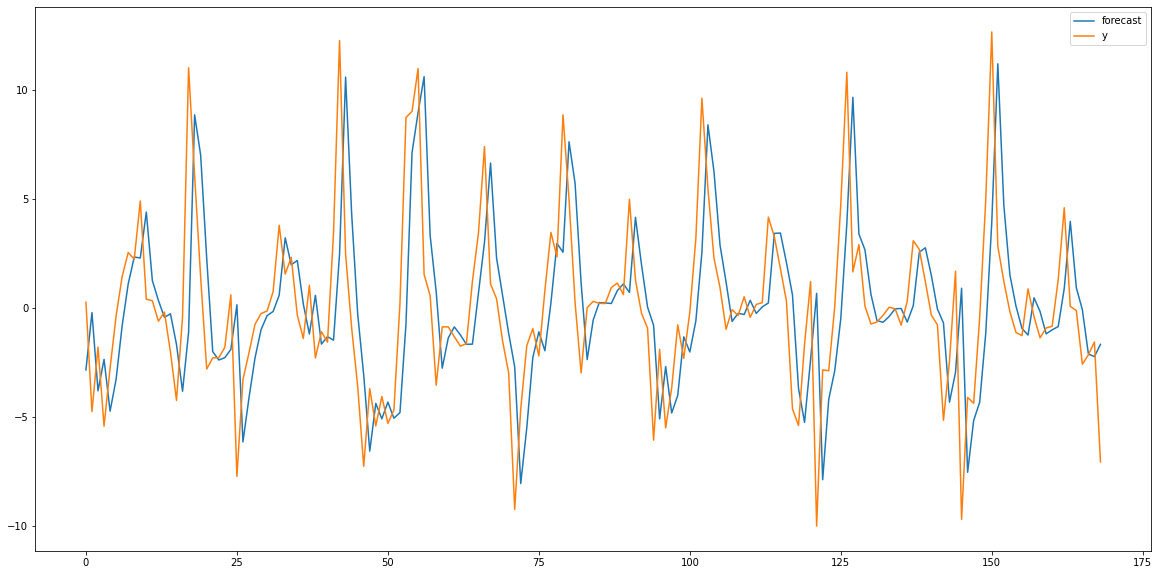

RMSE del precio de la electricidad, pronóstico multivariante de Arima: 4.104849349210201.
MAE del precio de la electricidad, pronóstico multivariante de Arima: 2.8175628215410935.


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

#27048
#Creamos nuestro modelo ARIMA y lo entrenamos
X = df_final['price actual'].diff().iloc[1:].values
X2 = X[:27048]
model = ARIMA(X2, order=(1,1,0))
result = model.fit()
print(result.summary())


#Pintamos parametros
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

#Criterio de información 
print("Criterio de información {}". format(result.aic))


plt.rcParams['figure.figsize'] = 20, 10

result.plot_predict(start=25079, end=2524)
plt.show()


#Calcuclamos el error RMSE
rmse = sqrt(mean_squared_error(df_final['price actual'].diff().iloc[25080:25249], result.predict(start=25080, end=25248)))
print("RMSE del precio de la electricidad, pronóstico multivariante de Arima: {}.".format(rmse))

#Calculamos el VARM
MAE = (np.absolute(df_final['price actual'].diff().iloc[25080:25249] - result.predict(start=25080, end=25248))).mean()
print("MAE del precio de la electricidad, pronóstico multivariante de Arima: {}.".format(MAE))





Modelo SARIMA

In [ ]:
#Creamos el modelo SARIMA y lo entrenamos
X = df_final['price actual'].diff().iloc[1:].values
X2 = X[:27048]
model = sm.tsa.SARIMAX(X2,order=(1,1,0))
result = model.fit()
#maxiter=10,disp=False
print(result.summary())

predicted_result = result.predict(start=25081, end=25249)


#Pintamos parametros
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

#Criterio de información 
print("Criterio de información {}". format(result.aic))


# Calculamos el error
rmse = sqrt(mean_squared_error(X2[25080:25249], predicted_result)) 
print("RMSE del precio de la electricidad, pronóstico multivariante de Sarima {}.".format(rmse))
print("\n")

MAE = (np.absolute(df_final['price actual'].diff().iloc[25080:25249] - predicted_result)).mean()
print("MAE del precio de la electricidad, pronóstico multivariante de Sarima: {}.".format(MAE))





#Gráfica de la predicción
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(X[25080:25248],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicho'])
plt.title('Load')
plt.show()


#Diagnostico
result.plot_diagnostics()



NameError: ignored

In [ ]:

# Check the current version of TensorFlow Decision Forests
print("Found TF-DF v" + tfdf.__version__)

# Download and assemble the Adult dataset.
dataset_path = tf.keras.utils.get_file(
    "adult.csv",
    "https://raw.githubusercontent.com/google/yggdrasil-decision-forests/"
    "main/yggdrasil_decision_forests/test_data/dataset/adult.csv")

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(dataset_path)  # "df" for Pandas's DataFrame.

print("First 3 examples:")
print(dataset_df.head(3))

Found TF-DF v0.1.7
First 3 examples:
   age         workclass  fnlwgt  ... hours_per_week  native_country income
0   39         State-gov   77516  ...             40   United-States  <=50K
1   50  Self-emp-not-inc   83311  ...             13   United-States  <=50K
2   38           Private  215646  ...             40   United-States  <=50K

[3 rows x 15 columns]


In [ ]:
# Note that the dataset contains a mix of numerical and categorical features.
# TensorFlow Decision Forests will handle them automatically! (e.g. no see for
# one-hot encoding or normalization; except for the label).

# Split the dataset into a training and a testing dataset.
test_indices = np.random.rand(len(dataset_df)) < 0.30
test_ds_pd = dataset_df[test_indices]
train_ds_pd = dataset_df[~test_indices]
print(f"{len(train_ds_pd)} examples in training"
      f", {len(test_ds_pd)} examples for testing.")

print(type(train_ds_pd))
print(type(train))
print(train_ds_pd.head(5))

22806 examples in training, 9755 examples for testing.
<class 'pandas.core.frame.DataFrame'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
   age         workclass  fnlwgt  ... hours_per_week  native_country income
1   50  Self-emp-not-inc   83311  ...             13   United-States  <=50K
3   53           Private  234721  ...             40   United-States  <=50K
5   37           Private  284582  ...             40   United-States  <=50K
6   49           Private  160187  ...             16         Jamaica  <=50K
7   52  Self-emp-not-inc  209642  ...             45   United-States   >50K

[5 rows x 15 columns]


In [ ]:
# Converts a Pandas dataset into a tensorflow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="income")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label="income")




<function tensorflow.python.data.ops.dataset_ops.DatasetV2.range>

In [ ]:
print(type(train_ds))
print(type(train))



<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


AttributeError: ignored

In [ ]:
print(type(validation))
print(type(test_ds))
train = train.batch(1)
validation = validation.batch(1)
print(type(train))
print(type(validation))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
print(train.enumerate())
print(train_ds.enumerate())

<ZipDataset shapes: ((), ((None, None, 24, 20), (None, None))), types: (tf.int64, (tf.float64, tf.float64))>
<ZipDataset shapes: ((), ({age: (None,), workclass: (None,), fnlwgt: (None,), education: (None,), education_num: (None,), marital_status: (None,), occupation: (None,), relationship: (None,), race: (None,), sex: (None,), capital_gain: (None,), capital_loss: (None,), hours_per_week: (None,), native_country: (None,)}, (None,))), types: (tf.int64, ({age: tf.int64, workclass: tf.string, fnlwgt: tf.int64, education: tf.string, education_num: tf.int64, marital_status: tf.string, occupation: tf.string, relationship: tf.string, race: tf.string, sex: tf.string, capital_gain: tf.int64, capital_loss: tf.int64, hours_per_week: tf.int64, native_country: tf.string}, tf.int64))>


In [ ]:


# Important: If you build the tf.dataset manually:
# - The batch size has no effect on the algorithm. 64 is a good default value.
# - Don't shuffle the training dataset (unlike Neural Net, the algorithm does
#   not benefit from shuffling). Bonus: The algorithm is deterministic (running
#   it twice on the same dataset will give the same model).
# - Don't use "repeats". The dataset should contain exactly one epoch.

# Trains the model.
model = tfdf.keras.RandomForestModel()
model.fit(x=train_ds)

# Note: If running in a Colab, ".fit()" will not print the training logs by
# default. To do so, you need to encapsulate the "fit()" in a
# "from wurlitzer import sys_pipescall" (see the colabs for some examples).

# Some information about the model.
# Different learning algorithm (and different hyper-parameters) can output
# different information.
print(model.summary())

# Evaluate the model on the validation dataset.
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds)

# The first entry is the BinaryCrossentropy loss. The next entries are specified
# by compile's metrics.
print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

# Export the model to the SavedModel format for later re-use e.g. TensorFlow
# Serving.
model.save("/tmp/my_saved_model")

# Note: This model is compatible with Yggdrasil Decision Forests.

# Look at the feature importances.
model.make_inspector().variable_importances()

360/360 [==============================] - 1s 2ms/step
Model: "random_forest_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	age
	capital_gain
	capital_loss
	education
	education_num
	fnlwgt
	hours_per_week
	marital_status
	native_country
	occupation
	race
	relationship
	sex
	workclass

No weights

Variable Importance: NUM_NODES:
    1.         "fnlwgt" 30987.000000 ################
    2.            "age" 25216.000000 ############
    3.     "occupation" 16289.000000 #######
    4. "hours_per_week" 14642.000000 ######
    5.      "workclass" 9570.000000 ###
    6.      "education" 8518.000000 ###
    7. "native_country" 5004.000000 #
    8.   "capital_loss" 4577.000000 #
    9.   "capital

KeyboardInterrupt: ignored

Random Forest (RF)


In [ ]:
tf.keras.backend.clear_session()

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="my_label")
#test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="my_label")

# Train a Random Forest model.
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

# Summary of the model structure.
model.summary()

# Evaluate the model.
model.evaluate(test_ds)

# Export the model to a SavedModel.
model.save("project/model")

NameError: ignored

# Sección de pruebas 

Conjunto de modelos que estoy probando y haciendo pruebas aún:

CNN

In [ ]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])
plot_model_rmse_and_loss(history)

multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

Time Distributed MLP

In [ ]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])
plot_model_rmse_and_loss(history)

multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

Encoder-Decoder

In [ ]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])
plot_model_rmse_and_loss(history)

encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))